In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from model import GPT
from evals import grammar_evals
from dgp import get_dataloader
import os
import pickle as pkl
import json
from sae import SAEData, SAE
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import random
import seaborn as sns
import math
from math import ceil
from tqdm import tqdm

# Load Model, Config, Data

In [2]:
path = 'results/scratch/3v4gwdfk' #['12owob2t', '3v4gwdfk', 'cpyib3ss']
state_dict = torch.load(os.path.join(path, 'latest_ckpt.pt'), map_location='cpu')
cfg = state_dict['config']

/var/folders/7s/t502n_qs6zg3d8hynhr0prpm0000gn/T/ipykernel_51584/2274623439.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path, 'l

In [3]:
with open(os.path.join(path, 'grammar/PCFG.pkl'), 'rb') as f:
    pcfg = pkl.load(f)
model = GPT(cfg.model, pcfg.vocab_size)
model.load_state_dict(state_dict['net'])
model.eval()
dataloader = get_dataloader(
        language=cfg.data.language,
        config=cfg.data.config,
        alpha=cfg.data.alpha,
        prior_type=cfg.data.prior_type,
        num_iters=cfg.data.num_iters * cfg.data.batch_size,
        max_sample_length=cfg.data.max_sample_length,
        seed=cfg.seed,
        batch_size=cfg.data.batch_size,
        num_workers=0,
    )

In [4]:
layer_name = 'res0'
data = SAEData(model_dir=path, ckpt='latest_ckpt.pt', layer_name=layer_name, config=False, device='cpu')
match layer_name:
    case "wte":   module = model.transformer.wte
    case "wpe":   module = model.transformer.wpe
    case "attn0": module = model.transformer.h[0].attn
    case "mlp0":  module = model.transformer.h[0].mlp
    case "res0":  module = model.transformer.h[0]
    case "attn1": module = model.transformer.h[1].attn
    case "mlp1":  module = model.transformer.h[1].mlp
    case "res1":  module = model.transformer.h[1]
    case "ln_f":  module = model.transformer.ln_f

Loading model...
Model loaded.


/Users/abhinavmenon/Desktop/Cambridge/pcfg-sae-causal/sae/data.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(os.path.join(self.model_dir, self

In [5]:
def get_samples(num_samples=128):
    template = dataloader.dataset.template
    dec = dataloader.dataset.decorator_length
    grammar = dataloader.dataset.PCFG
    inputs = template.repeat(num_samples, 1)
    samples, per_token_logprobs = model.sample(
        inputs=inputs, 
        max_new_tokens=cfg.data.max_sample_length - 10, 
        retrieve_llhoods='tokens',
        )
    sentences = [grammar.detokenize_sentence(s[dec:]).split('<eos>')[0].strip() for s in samples]
    logprobs = [per_token_logprobs[i][dec:][:len(sentences[i].split())] for i in range(num_samples)]
    return sentences, logprobs

# Causal Interventions

## Getter Functions

In [6]:
def get_sae(idx):
    embedding_size = data[0][0].size(-1)
    args = json.load(open(os.path.join(path, f'sae_{idx}/config.json')))
    sae = SAE(embedding_size, args['exp_factor'] * embedding_size, k=args['k'], sparsemax=args['sparsemax'] if 'sparsemax' in args.keys() else False, pre_bias=args['pre_bias'] if 'pre_bias' in args.keys() else False, norm=args['norm'] if 'norm' in args.keys() else '')
    state_dict = torch.load(os.path.join(path, f'sae_{idx}/model.pth'), map_location='cpu')
    sae.load_state_dict(state_dict)
    sae.eval()
    return sae

def get_config(idx):
    return json.load(open(os.path.join(path, F'sae_{idx}/config.json')))

In [7]:
def get_latents_and_sequences(sae, num_sequences=128):
    latents = []
    sequences = []
    dec = dataloader.dataset.decorator_length
    pcfg = dataloader.dataset.PCFG
    pad = pcfg.vocab['<pad>']
    eos = pcfg.vocab['<eos>']

    for _ in range(num_sequences):
        activn, grad, seq = data[0]
        latent, _ = sae(activn)
        latents.append(latent.detach())
        sequences.append([c for c in seq.tolist() if c not in [pad, eos]][dec:])

    latents = torch.cat(latents, dim=0)
    return latents, sequences


In [8]:
def get_feature_set(sae, pos, threshold):
    latents, sequences = get_latents_and_sequences(sae, num_sequences=128)
    latents_by_sequence = []
    temp = latents.clone()
    for sequence in sequences:
        latents_by_sequence.append(temp[:len(sequence)])
        temp = temp[len(sequence):]

    correlations = []
    features = []
    for fidx in range(latents.size(-1)):
        pos_ft = []
        activations = []
        for i in range(len(sequences)):
            activations += latents_by_sequence[i][:, fidx].tolist()
            pos_ft += [1 if pcfg.id_to_token_map[token][:-1] == pos else 0 for token in sequences[i]]
    
        र = torch.corrcoef(torch.tensor([activations, pos_ft]))[0, 1].item()
        #if abs(र) >= threshold:
        if र >= threshold:
            features.append(fidx)
            correlations.append(र)
    
    features = sorted(features, key=lambda x: correlations[features.index(x)], reverse=True)
    return features, correlations

def get_next_token_feature_set(sae, pos, threshold):
    latents, sequences = get_latents_and_sequences(sae, num_sequences=128)
    latents_by_sequence = []
    temp = latents.clone()
    for sequence in sequences:
        latents_by_sequence.append(temp[:len(sequence)])
        temp = temp[len(sequence):]

    correlations = []
    features = []
    for fidx in range(latents.size(-1)):
        pos_ft = []
        activations = []
        for i in range(len(sequences)):
            activations += latents_by_sequence[i][:, fidx].tolist()[:-1]
            pos_ft += [1 if pcfg.id_to_token_map[token][:-1] == pos else 0 for token in sequences[i][1:]]

        र = torch.corrcoef(torch.tensor([activations, pos_ft]))[0, 1].item()
        #if abs(र) >= threshold:
        if र >= threshold:
            features.append(fidx)
            correlations.append(र)

    features = sorted(features, key=lambda x: correlations[features.index(x)], reverse=True)
    return features, correlations

def get_subj_feature_set(sae, threshold):
    latents, sequences = get_latents_and_sequences(sae, num_sequences=128)
    latents_by_sequence = []
    temp = latents.clone()
    for sequence in sequences:
        latents_by_sequence.append(temp[:len(sequence)])
        temp = temp[len(sequence):]

    correlations = []
    features = []
    for fidx in range(latents.size(-1)):
        pos_ft = []
        activations = []
        for i in range(len(sequences)):
            activations += latents_by_sequence[i][:, fidx].tolist()
            v = [t[:-1] for t in pcfg.detokenize_sentence(sequences[i]).split(' ')].index('verb')
            pos_ft += [1 if pcfg.id_to_token_map[token][:-1] in ['pro', 'noun'] and j <= v else 0 for j, token in enumerate(sequences[i])]

        र = torch.corrcoef(torch.tensor([activations, pos_ft]))[0, 1].item()
        #if abs(र) >= threshold:
        if र >= threshold:
            features.append(fidx)
            correlations.append(र)

    features = sorted(features, key=lambda x: correlations[features.index(x)], reverse=True)
    return features, correlations
 
def get_noun_conj_feature_set(sae, threshold):
    latents, sequences = get_latents_and_sequences(sae, num_sequences=128)
    latents_by_sequence = []
    temp = latents.clone()
    for sequence in sequences:
        latents_by_sequence.append(temp[:len(sequence)])
        temp = temp[len(sequence):]

    correlations = []
    features = []
    for fidx in range(latents.size(-1)):
        pos_ft = []
        activations = []
        for i in range(len(sequences)):
            activations += latents_by_sequence[i][:, fidx].tolist()
            pos_ft += [1 if pcfg.id_to_token_map[token][:-1] == 'conj' and \
                         pcfg.id_to_token_map[sequences[i][j+1]][:-1] in ['adj', 'noun']
                       else 0
                        for j, token in enumerate(sequences[i])]

        र = torch.corrcoef(torch.tensor([activations, pos_ft]))[0, 1].item()
        #if abs(र) >= threshold:
        if र >= threshold:
            features.append(fidx)
            correlations.append(र)

    features = sorted(features, key=lambda x: correlations[features.index(x)], reverse=True)
    return features, correlations
 

## Interventions and Measures

In [9]:
def fuck_with_model(hook, measures, show_samples=False):
    """
    Compare the value of some measure on model generations
    before and after intervening to null out a certain feature.
    The measures must each accept a string (the sentence) and a list of logprobs
    and return a scalar.
    """
    clean_samples, clean_logprobs = get_samples(100)
    if show_samples:
        print("Clean:")
        print('\n'.join(clean_samples[:show_samples]))

    handle = module.register_forward_hook(hook)
    dirty_samples, dirty_logprobs = get_samples(100)
    handle.remove()
    if show_samples:
        print("Dirty:")
        print('\n'.join(dirty_samples[:show_samples]))

    clean_measures = [[measure(sample, logprobs)
                        for sample, logprobs in zip(clean_samples, clean_logprobs)]
                            for measure in measures]
    dirty_measures = [[measure(sample, logprobs)
                         for sample, logprobs in zip(dirty_samples, dirty_logprobs)]
                            for measure in measures]

    return clean_measures, dirty_measures

In [10]:
def is_grammatical(s, logprobs):
    (grammatical, _, _, _), _ = pcfg.check_grammaticality(s)
    return 1 if grammatical else 0

In [11]:
def pos_count(pos):
    def measure(s, logprobs):
        return s.count(pos)
    return measure

def pos_fraction(pos):
    def measure(s, logprobs):
        return s.count(pos) / len(s.split()) if len(s.split()) != 0 else 0
    return measure

def pos_logprobs(pos):
    def measure(s, logprobs):
        return sum(lp for w, lp in zip(s.split(), logprobs) if w[:-1] == pos)
    return measure

def pos_logprob_fraction(pos):
    def measure(s, logprobs):
        return sum(lp for w, lp in zip(s.split(), logprobs) if w[:-1] == pos) / sum(logprobs) if sum(logprobs) != 0 else 0
    return measure

In [12]:
def depth(s, logprobs):
    stack = 0
    m = 0
    for t in s.split():
        if t[0] == 'o': stack += 1
        else: stack -= 1
        m = max(m, stack)
    return m

In [13]:
def length(s, logprobs):
    return len(s.split())

## Hooks and Ranges

In [14]:
def get_range_of_latent(sae, fidx, num_batches=1):
    activations = []
    if isinstance(fidx, int): fidx = [fidx]
    def hook(module, input, output):
        nonlocal activations
        latent, _ = sae(output)
        activations += (latent.index_select(-1, torch.tensor(fidx, dtype=torch.int32)))

    handle = module.register_forward_hook(hook)
    for _ in range(num_batches):
        batch, _ = next(iter(dataloader))
        model(batch)
    handle.remove()
    act = torch.stack(activations, 0)
    return act.min().item(), act.max().item()

def get_hook(sae, fidx, clamp_value):
    """fidx can be an index or a list of indices"""
    def hook(module, input, output):
        latent, _ = sae(output)
        latent.index_fill_(-1, torch.tensor(fidx, dtype=torch.int64), clamp_value)
        recon = sae.decoder(latent)
        return recon
    return hook

def get_complement_hook(sae, fidx):
    def hook(module, input, output):
        latent, _ = sae(output)
        indices = [i for i in range(latent.size(-1)) if i not in fidx]
        latent.index_fill_(-1, torch.tensor(indices), 0)
        recon = sae.decoder(latent)
        return recon
    return hook

## Sample-wise Interventions & Visualizations

First, we can try to set a certain feature to zero and examine the generations that result.

We examine the distributions of some function of the generations, and how they change by intervening via the SAE.

In [15]:
sae = get_sae(3)
fidx, c = get_feature_set(sae, 'adj', 0.9)
print(len(fidx))
#print(fidx)
print(c)
if (len(fidx) == 0):
    print("No features found")

/var/folders/7s/t502n_qs6zg3d8hynhr0prpm0000gn/T/ipykernel_50649/385031657.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path, f's

16
[0.9926154613494873, 0.9893808960914612, 0.9931654930114746, 0.987479031085968, 0.9231357574462891, 0.9891872406005859, 0.9885061383247375, 0.9931276440620422, 0.9803340435028076, 0.9366540908813477, 0.982404887676239, 0.9923113584518433, 0.9884994626045227, 0.9905518293380737, 0.9754077196121216, 0.9816153645515442]


In [16]:
#fidx = fidx[:-10]
#print(len(fidx))
vmin, vmax = get_range_of_latent(sae, fidx)
print(vmin, vmax)

parts_of_speech = ['noun', 'pro', 'adj', 'verb', 'adv', 'conj']

clamp = 100
#clean_measures, dirty_measures = fuck_with_model(get_hook(sae, fidx, clamp), 
                                                 #[is_grammatical, depth], show_samples=20)
                                                 #[pos_count(pos) for pos in parts_of_speech])
                                                 #[pos_fraction(pos) for pos in parts_of_speech])
                                                 #[pos_logprobs(pos) for pos in parts_of_speech])
                                                 #[pos_logprob_fraction(pos) for pos in parts_of_speech])

#clean_measures, dirty_measures = fuck_with_model(get_complement_hook(sae, fidx),
#                                                 #[pos_count(pos) for pos in parts_of_speech])
#                                                 #[pos_fraction(pos) for pos in parts_of_speech])
#                                                 #[pos_logprobs(pos) for pos in parts_of_speech])
#                                                 #[pos_logprob_fraction(pos) for pos in parts_of_speech])

0.0 859.1279907226562


In [17]:
for i in range(1):
    plt.violinplot([clean_measures[i], dirty_measures[i]], positions=[0, 1], showmeans=True)
    plt.xticks([0, 1], labels=['clean', 'dirty'])
    plt.title(parts_of_speech[i])
    plt.show()

NameError: name 'clean_measures' is not defined

## Sweep

We also run a sweep on the clamp values and examine the grammaticality (and other measures) on the outputs.

In [27]:
sae = get_sae(0)

for POS in ['adj', 'verb', 'adv']:
    for k in ([4, 2] if POS == 'adj' else \
              [5, 4, 3, 2] if POS == 'verb' else \
              [13, 7, 4, 2]):
        fidx, c = get_feature_set(sae, POS, 0.9)
        fidx = random.sample(fidx, k)
        print(POS, k, fidx)
        vmin, vmax = get_range_of_latent(sae, fidx)
        print(vmin, vmax)

        parts_of_speech = ['noun', 'pro', 'adj', 'verb', 'adv', 'conj']
        dirtys = [[] for _ in range(6)]
        grm = []
        intervals = 10
        clamps = [(-1 + (2/intervals) * c) * vmax for c in range(intervals+1)]
        for clamp in tqdm(clamps):
            _, ds = fuck_with_model(get_hook(sae, fidx, clamp), [pos_logprob_fraction(pos) for pos in parts_of_speech] + [is_grammatical])
            for i in range(6):
                dirtys[i].append(ds[i])
            grm.append(ds[-1])

        for i in range(6):
            dirtys[i] = [sum(c)/len(c) for c in dirtys[i]]

        for i in range(1, 6):
            dirtys[i] = [d+d1 for d, d1 in zip(dirtys[i], dirtys[i-1])]

        plt.plot(dirtys[0], label='noun')
        plt.plot(dirtys[1], label='pro')
        plt.plot(dirtys[2], label='adj')
        plt.plot(dirtys[3], label='verb')
        plt.plot(dirtys[4], label='adv')
        plt.plot(dirtys[5], label='conj')
        plt.fill_between(range(intervals+1), 0,         dirtys[0])
        plt.fill_between(range(intervals+1), dirtys[0], dirtys[1])
        plt.fill_between(range(intervals+1), dirtys[1], dirtys[2])
        plt.fill_between(range(intervals+1), dirtys[2], dirtys[3])
        plt.fill_between(range(intervals+1), dirtys[3], dirtys[4])
        plt.fill_between(range(intervals+1), dirtys[4], dirtys[5])

        plt.xticks(range(intervals+2), labels=[f'{(-1 + (2/intervals) * c) * vmax:.2f}' for c in range(intervals+1)] + [''], rotation=45)
        plt.rcParams['axes.spines.right'] = False
        plt.rcParams['axes.spines.top'] = False
        plt.xlabel('Clamp Value')
        plt.savefig(f'caus_{POS}_pos_frac_{k}.pdf', dpi=400, bbox_inches='tight')
        plt.show()

        plt.plot([sum(c)/len(c) for c in grm], label='Grammaticality', marker='o', color='pink')
        plt.xticks(range(intervals+1), labels=[f'{(-1 + (2/intervals) * c) * vmax:.2f}' for c in range(intervals+1)], rotation=45)
        plt.xlabel('Clamp Value')
        plt.savefig(f'caus_{POS}_gram_{k}.pdf', dpi=400, bbox_inches='tight')
        plt.show()

/var/folders/7s/t502n_qs6zg3d8hynhr0prpm0000gn/T/ipykernel_51584/385031657.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path, f's

[71, 129, 182, 124]
0.0 630.26806640625


  0%|          | 0/11 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [22]:
for i in range(6):
    dirtys[i] = [sum(c)/len(c) for c in dirtys[i]]

In [23]:
for i in range(1, 6):
    dirtys[i] = [d+d1 for d, d1 in zip(dirtys[i], dirtys[i-1])]

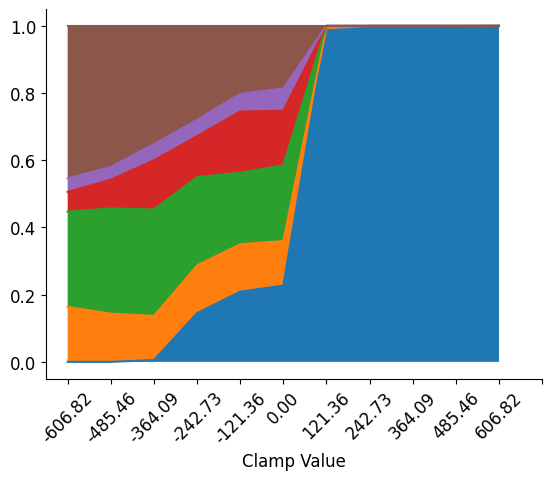

In [25]:
plt.plot(dirtys[0], label='noun')
plt.plot(dirtys[1], label='pro')
plt.plot(dirtys[2], label='adj')
plt.plot(dirtys[3], label='verb')
plt.plot(dirtys[4], label='adv')
plt.plot(dirtys[5], label='conj')
plt.fill_between(range(intervals+1), 0,         dirtys[0])
plt.fill_between(range(intervals+1), dirtys[0], dirtys[1])
plt.fill_between(range(intervals+1), dirtys[1], dirtys[2])
plt.fill_between(range(intervals+1), dirtys[2], dirtys[3])
plt.fill_between(range(intervals+1), dirtys[3], dirtys[4])
plt.fill_between(range(intervals+1), dirtys[4], dirtys[5])

plt.xticks(range(intervals+2), labels=[f'{(-1 + (2/intervals) * c) * vmax:.2f}' for c in range(intervals+1)] + [''], rotation=45)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.xlabel('Clamp Value')
plt.savefig(f'caus_{POS}_pos_frac_{k}.pdf', dpi=400, bbox_inches='tight')
#plt.show()

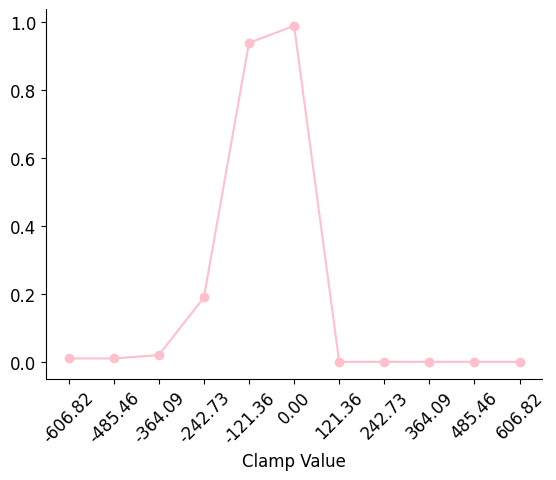

In [26]:
plt.plot([sum(c)/len(c) for c in grm], label='Grammaticality', marker='o', color='pink')
#plt.plot([sum(c)/len(c) for c in dirtys[0]], label='Gram')
plt.xticks(range(intervals+1), labels=[f'{(-1 + (2/intervals) * c) * vmax:.2f}' for c in range(intervals+1)], rotation=45)
plt.xlabel('Clamp Value')
plt.savefig(f'caus_{POS}_gram_{k}.pdf', dpi=400, bbox_inches='tight')
plt.show()

## Logits

Change in predictions for each token on ablation.

/var/folders/7s/t502n_qs6zg3d8hynhr0prpm0000gn/T/ipykernel_24357/385031657.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path, f's

pro2 verb2 adj6 noun1 adv3
5


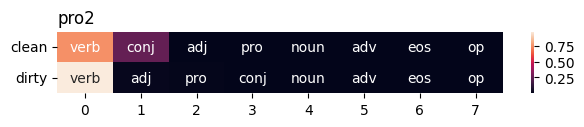

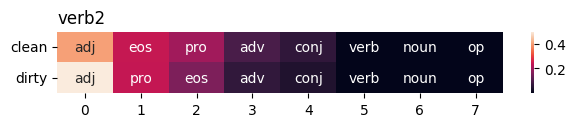

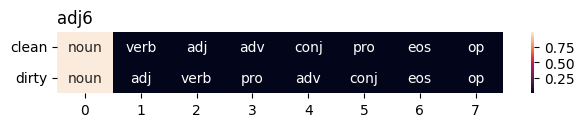

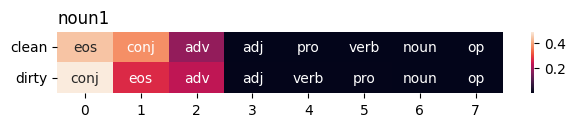

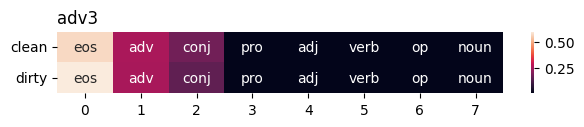

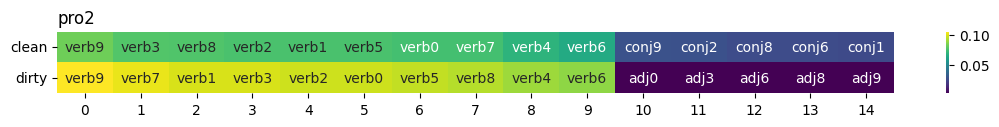

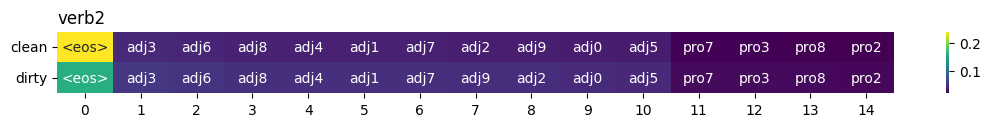

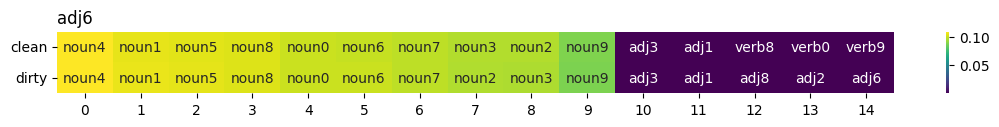

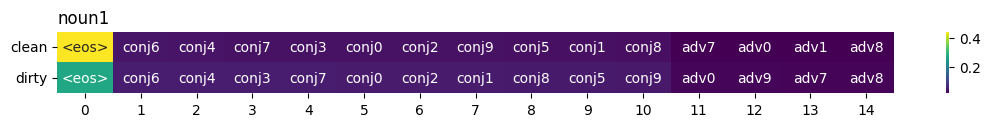

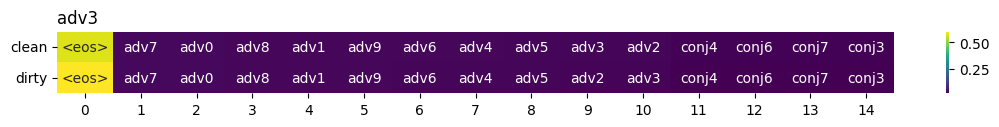

In [40]:
sae = get_sae(0)
fidx, _ = get_noun_conj_feature_set(sae, 0.7) #get_feature_set(sae, 'adv', 0.9)
clamp = 400

_, clean_logits, sequence = data[0]
length = int(clean_logits.size(0))

hook = get_hook(sae, fidx, clamp)
handle = module.register_forward_hook(hook)
dirty_logits = model(sequence.unsqueeze(0))
dirty_logits = dirty_logits.squeeze(0)[data.dataset.decorator_length:data.dataset.decorator_length + length]
handle.remove()

sequence = sequence[data.dataset.decorator_length:]
print(pcfg.detokenize_sentence(sequence).split('<eos>')[0].strip())
print(length)

for i in range(clean_logits.size(0)):
    # Plot probabilities by grouping by part of speech
    clean_probs = F.softmax(clean_logits[i], dim=-1)
    dirty_probs = F.softmax(dirty_logits[i], dim=-1)
    clean_pos_probs = [clean_probs[0:10].sum(), # nouns
                       clean_probs[10:20].sum(), # verbs
                       clean_probs[20:30].sum(), # adjectives
                       clean_probs[30:40].sum(), # pronouns
                       clean_probs[40:50].sum(), # adverbs
                       clean_probs[50:60].sum(), # conjunctions
                       clean_probs[66], # eos
                       clean_probs[61:66].sum() + clean_probs[67:].sum()] # other
    clean_val, clean_ind = torch.sort(torch.tensor(clean_pos_probs), descending=True)

    dirty_pos_probs = [dirty_probs[0:10].sum(), # nouns
                       dirty_probs[10:20].sum(), # verbs
                       dirty_probs[20:30].sum(), # adjectives
                       dirty_probs[30:40].sum(), # pronouns
                       dirty_probs[40:50].sum(), # adverbs
                       dirty_probs[50:60].sum(), # conjunctions
                       dirty_probs[66], # eos
                       dirty_probs[61:66].sum() + dirty_probs[67:].sum()] # other
    dirty_val, dirty_ind = torch.sort(torch.tensor(dirty_pos_probs), descending=True)

    plt.figure(figsize = (7.2, 0.8))
    sns.heatmap(torch.stack([clean_val, dirty_val], dim=0).detach().numpy(),
                yticklabels=['clean', 'dirty'],
                annot=[[['noun', 'verb', 'adj', 'pro', 'adv', 'conj', 'eos', 'op'][i] for i in clean_ind],
                       [['noun', 'verb', 'adj', 'pro', 'adv', 'conj', 'eos', 'op'][i] for i in dirty_ind]],
                fmt='', cmap='rocket')
    plt.title(pcfg.id_to_token_map[sequence[i].item()], loc='left')
    plt.show()

k = 15
for i in range(clean_logits.size(0)):
    # Plot top k tokens for clean and dirty logits
    top_k_clean_log, top_k_clean_ind = torch.topk(F.softmax(clean_logits[i], dim=-1), k)
    top_k_dirty_log, top_k_dirty_ind = torch.topk(F.softmax(dirty_logits[i], dim=-1), k)
    labels = [[pcfg.id_to_token_map[i.item()] for i in top_k_clean_ind], [pcfg.id_to_token_map[i.item()] for i in top_k_dirty_ind]]
    plt.figure(figsize = (k * 0.9, 0.8))
    sns.heatmap(torch.stack([top_k_clean_log, top_k_dirty_log], 0).detach().numpy(), yticklabels=['clean', 'dirty'], annot=labels, fmt='', cmap='viridis')
    plt.title(pcfg.id_to_token_map[sequence[i].item()], loc='left')
    plt.show()

Average change in prediction across PoS.

/var/folders/7s/t502n_qs6zg3d8hynhr0prpm0000gn/T/ipykernel_41960/385031657.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path, f's

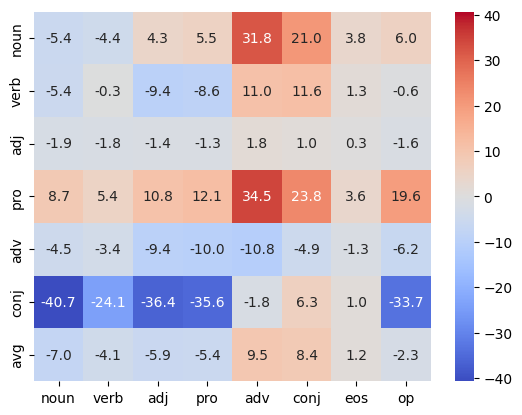

In [52]:
sae = get_sae(0)
fidx, _ = get_feature_set(sae, 'adv', 0.9)
clamp = 100

logit_diffs = torch.zeros(7, 8)
counts = [0 for _ in range(8)]
for e in range(10):
    _, clean_logits, sequence = data[0]
    length = int(clean_logits.size(0))

    hook = get_hook(sae, fidx, clamp)
    handle = module.register_forward_hook(hook)
    dirty_logits = model(sequence.unsqueeze(0))
    dirty_logits = dirty_logits.squeeze(0)[data.dataset.decorator_length:data.dataset.decorator_length + length]
    handle.remove()
    sequence = sequence[data.dataset.decorator_length:]

    for i in range(length):
        pos_i = ['noun', 'verb', 'adj', 'pro', 'adv', 'conj'].index(pcfg.id_to_token_map[sequence[i].item()][:-1])
        updates = [dirty_logits[i][0:10 ].sum() - clean_logits[i][0:10].sum(),
                   dirty_logits[i][10:20].sum() - clean_logits[i][10:20].sum(),
                   dirty_logits[i][20:30].sum() - clean_logits[i][20:30].sum(),
                   dirty_logits[i][30:40].sum() - clean_logits[i][30:40].sum(),
                   dirty_logits[i][40:50].sum() - clean_logits[i][40:50].sum(),
                   dirty_logits[i][50:60].sum() - clean_logits[i][50:60].sum(),
                   dirty_logits[i][66]          - clean_logits[i][66].sum(),
                   dirty_logits[i][61:66].sum() + dirty_logits[i][67:].sum() - clean_logits[i][61:66].sum() - clean_logits[i][67:].sum()]
        for j in range(8):
            logit_diffs[pos_i][j] += updates[j]
        counts[pos_i] += 1

for i in range(6):
    for j in range(8):
        logit_diffs[i][j] /= counts[i]

logit_diffs[-1] = logit_diffs.mean(dim=0)
lim = max(abs(logit_diffs.min().item()), abs(logit_diffs.max().item()))

sns.heatmap(logit_diffs.detach().numpy(), annot=True, fmt='.1f', cmap='coolwarm', 
            xticklabels=['noun', 'verb', 'adj', 'pro', 'adv', 'conj', 'eos', 'op'],
            yticklabels=['noun', 'verb', 'adj', 'pro', 'adv', 'conj', 'avg'],
            vmin=-lim, vmax=lim)
plt.show()

Average change in prediction by PoS.

/var/folders/7s/t502n_qs6zg3d8hynhr0prpm0000gn/T/ipykernel_41960/385031657.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path, f's

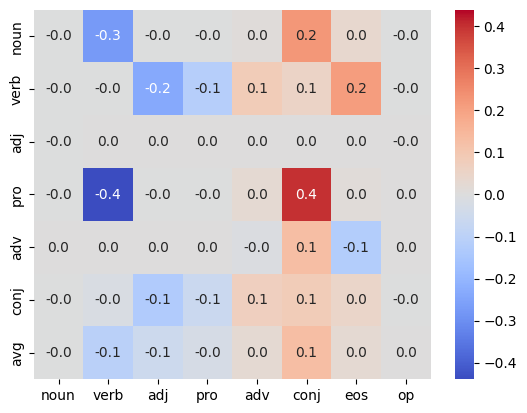

In [58]:
sae = get_sae(0)
fidx, _ = get_feature_set(sae, 'adv', 0.9)
clamp = 100

logit_diffs = torch.zeros(7, 8)
counts = [0 for _ in range(8)]
for e in range(10):
    _, clean_logits, sequence = data[0]
    length = int(clean_logits.size(0))

    hook = get_hook(sae, fidx, clamp)
    handle = module.register_forward_hook(hook)
    dirty_logits = model(sequence.unsqueeze(0))
    dirty_logits = dirty_logits.squeeze(0)[data.dataset.decorator_length:data.dataset.decorator_length + length]
    handle.remove()
    sequence = sequence[data.dataset.decorator_length:]

    clean_probs = F.softmax(clean_logits, dim=-1)
    dirty_probs = F.softmax(dirty_logits, dim=-1)
    for i in range(length):
        pos_i = ['noun', 'verb', 'adj', 'pro', 'adv', 'conj'].index(pcfg.id_to_token_map[sequence[i].item()][:-1])
        updates = [(dirty_probs[i][0:10 ].sum() - clean_probs[i][0:10].sum() ),
                   (dirty_probs[i][10:20].sum() - clean_probs[i][10:20].sum()),
                   (dirty_probs[i][20:30].sum() - clean_probs[i][20:30].sum()),
                   (dirty_probs[i][30:40].sum() - clean_probs[i][30:40].sum()),
                   (dirty_probs[i][40:50].sum() - clean_probs[i][40:50].sum()),
                   (dirty_probs[i][50:60].sum() - clean_probs[i][50:60].sum()),
                   (dirty_probs[i][66]          - clean_probs[i][66].sum()   ),
                   (dirty_probs[i][61:66].sum() + dirty_probs[i][67:].sum() - clean_probs[i][61:66].sum() - clean_probs[i][67:].sum())]
        for j in range(8):
            logit_diffs[pos_i][j] += updates[j]
        counts[pos_i] += 1

for i in range(6):
    for j in range(8):
        logit_diffs[i][j] /= counts[i]

logit_diffs[-1] = logit_diffs.mean(dim=0)
lim = max(abs(logit_diffs.min().item()), abs(logit_diffs.max().item()))

sns.heatmap(logit_diffs.detach().numpy(), annot=True, fmt='.1f', cmap='coolwarm', 
            xticklabels=['noun', 'verb', 'adj', 'pro', 'adv', 'conj', 'eos', 'op'],
            yticklabels=['noun', 'verb', 'adj', 'pro', 'adv', 'conj', 'avg'],
            vmin=-lim, vmax=lim)
plt.show()

## Attention Visualization

### Attention probabilities

In [15]:
def attn_viz_hook(module, input, output):
    global length, attn
    s = data.dataset.decorator_length
    attn = output.squeeze(0)[s:s+length, s:s+length]
    attn = attn.detach().numpy()
    #plt.figure(figsize=(8, 8))
    #sns.heatmap(attn, cmap='viridis',
    #            xticklabels=pcfg.detokenize_sentence(sequence[s:s+length]).split(),
    #            yticklabels=pcfg.detokenize_sentence(sequence[s:s+length]).split())
    #plt.show()

/var/folders/7s/t502n_qs6zg3d8hynhr0prpm0000gn/T/ipykernel_35583/385031657.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path, f's

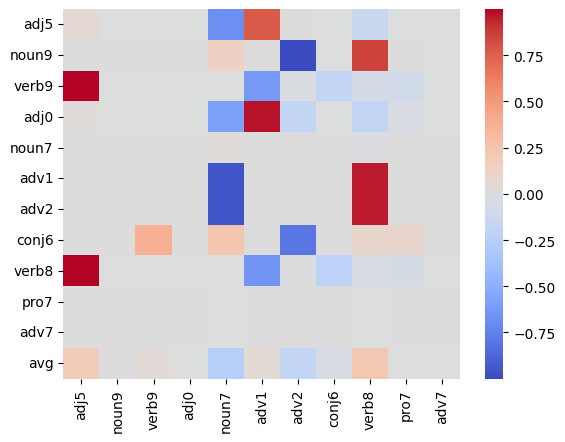

In [16]:
sae = get_sae(0)
fidx, _ = get_feature_set(sae, 'adj', 0.9)
clamp = 100

s = data.dataset.decorator_length
length = 0
while length < 10:
    _, clean_logits, sequence = data[0]
    length = int(clean_logits.size(0))

layer = 1

attn = None
handle = model.transformer.h[layer].attn.register_forward_hook(attn_viz_hook)
model(sequence.unsqueeze(0))
handle.remove()

clean_attn = attn.copy()
#clean_attn = torch.concat([clean_attn, clean_attn.mean(dim=0, keepdim=True)], dim=0)
#sns.heatmap(clean_attn, cmap='Reds',
#            xticklabels=pcfg.detokenize_sentence(sequence[s:s+length]).split(),
#            yticklabels=pcfg.detokenize_sentence(sequence[s:s+length]).split() + ['avg'],
#            vmin=0, vmax=1)
#plt.show()

hook = get_hook(sae, fidx, clamp)
handle_int = module.register_forward_hook(hook)
handle_attn = model.transformer.h[layer].attn.register_forward_hook(attn_viz_hook)
model(sequence.unsqueeze(0))
handle_int.remove()
handle_attn.remove()

dirty_attn = attn.copy()
#sns.heatmap(dirty_attn, cmap='viridis',
#            xticklabels=pcfg.detokenize_sentence(sequence[s:s+length]).split(),
#            yticklabels=pcfg.detokenize_sentence(sequence[s:s+length]).split())
#plt.show()

diff = F.softmax(torch.tensor(dirty_attn), dim=1) - F.softmax(torch.tensor(clean_attn), dim=1)
diff = torch.concat([diff, diff.mean(dim=0, keepdim=True)], dim=0)
m = max(abs(diff.min()), abs(diff.max()))
sns.heatmap(diff, cmap='coolwarm',
            xticklabels=pcfg.detokenize_sentence(sequence[s:s+length]).split(),
            yticklabels=pcfg.detokenize_sentence(sequence[s:s+length]).split() + ['avg'],
            vmax=m, vmin=-m)
plt.show()

### The Actual Matrices

/var/folders/7s/t502n_qs6zg3d8hynhr0prpm0000gn/T/ipykernel_59829/385031657.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path, f's

tensor(-0.4520) tensor(0.4726)


<Axes: >

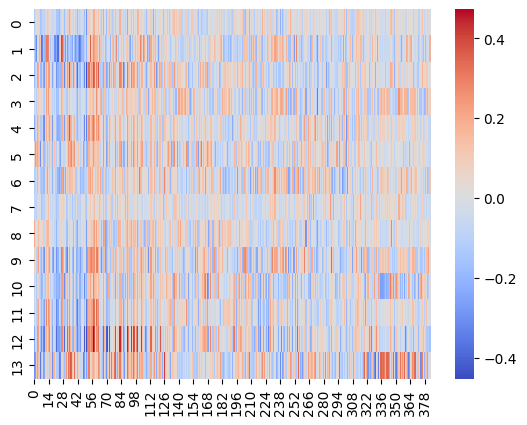

In [117]:
sae = get_sae(0)
fidx, c = get_feature_set(sae, 'adv', 0.8)

directions = sae.decoder.weight.data.shape
directions = torch.index_select(sae.decoder.weight.data, 1, torch.tensor(fidx, dtype=torch.int64)).T # [15, 128]

kqv = model.transformer.h[1].attn.c_attn.weight.data # [384, 128]

# compute pairwise cosine similarity between directions and attention rows
similarity = torch.matmul(directions, kqv.T)
similarity = similarity / torch.norm(directions, dim=1).unsqueeze(1)
similarity = similarity / torch.norm(kqv, dim=1).unsqueeze(0)

print(similarity.min(), similarity.max())

sns.heatmap(similarity.detach().numpy(), cmap='coolwarm')

## Circuits

In [42]:
sae = get_sae(0)
fidx, _ = get_feature_set(sae, 'adj', 0.9)
fidx = random.sample(fidx, 1)
clamp = get_range_of_latent(sae, fidx)[1]
print(fidx, clamp)

length = 0
while length < 10:
    _, clean_logits, sequence = data[0]
    length = int(clean_logits.size(0))
dec = data.dataset.decorator_length
print(pcfg.detokenize_sentence(sequence[dec : dec + length]).split('<eos>')[0].strip())

/var/folders/7s/t502n_qs6zg3d8hynhr0prpm0000gn/T/ipykernel_51058/385031657.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path, f's

[92] 520.6002197265625
adj7 noun8 conj5 noun0 conj6 adj1 noun1 verb6 conj4 verb8


In [43]:
clean_latent_values = None
clean_reconstruction = None
dirty_reconstruction = None
def hook(module, input, output):
    global clean_latent_values, clean_reconstruction, dirty_reconstruction
    latent, recon = sae(output)
    clean_latent_values = latent.clone().index_select(-1, torch.tensor(fidx, dtype=torch.int64)).squeeze(0)
    clean_reconstruction = recon.clone()
    latent.index_fill_(-1, torch.tensor(fidx, dtype=torch.int64), clamp)
    recon = sae.decoder(latent)
    dirty_reconstruction = recon.clone()
    return recon

handle = module.register_forward_hook(hook)
dirty_logits = model(sequence.unsqueeze(0)).squeeze(0)[dec:dec+length]
handle.remove()

What are the initial values of the latents, and how much do they change the embedding by?  
Can this be approximated to the simple sum of SAE directions?

Yes.

In [44]:
change_in_reconstruction = (dirty_reconstruction - clean_reconstruction).squeeze() # [seq, h]

change_in_latent = (clamp - clean_latent_values).unsqueeze(1).repeat(1, 128, 1) # [seq, h, 15]
sae_directions = sae.decoder.weight.data.index_select(1, torch.tensor(fidx, dtype=torch.int64)).unsqueeze(0).repeat(128, 1, 1) # [seq, h, 15]

expected_change_in_reconstruction = (sae_directions * change_in_latent).sum(dim=-1) # [seq, h]

In [45]:
def effect_on_module(m, hook):
    output_of_m = None
    def m_hook(module, input, output):
        nonlocal output_of_m
        output_of_m = output.squeeze(0)

    handle_m = m.register_forward_hook(m_hook)
    model(sequence.unsqueeze(0))
    handle_m.remove()

    clean_output = output_of_m.clone()

    handle_m = m.register_forward_hook(m_hook)
    handle = module.register_forward_hook(hook)
    model(sequence.unsqueeze(0))
    handle_m.remove()
    handle.remove()

    dirty_output = output_of_m.clone()

    change_in_m_output = dirty_output - clean_output
    return clean_output, dirty_output, change_in_m_output

Now, we examine the contribution to the effect of the intervention from each of three terms:  
$x$; $\operatorname{attn}(x)$; $\operatorname{MLP}(x + \operatorname{attn}(x))$

We have already computed $\Delta x$ above; we now compute $\Delta \operatorname{attn}(x)$ and $\Delta \operatorname{MLP}(x)$.

In [46]:
clean_attn, dirty_attn, change_in_attn = effect_on_module(model.transformer.h[1].attn, hook)
clean_mlp,  dirty_mlp,  change_in_mlp  = effect_on_module(model.transformer.h[1].mlp, hook)

changes = torch.stack([change_in_reconstruction, change_in_attn, change_in_mlp], dim=0)

print(changes.shape)

torch.Size([3, 128, 128])


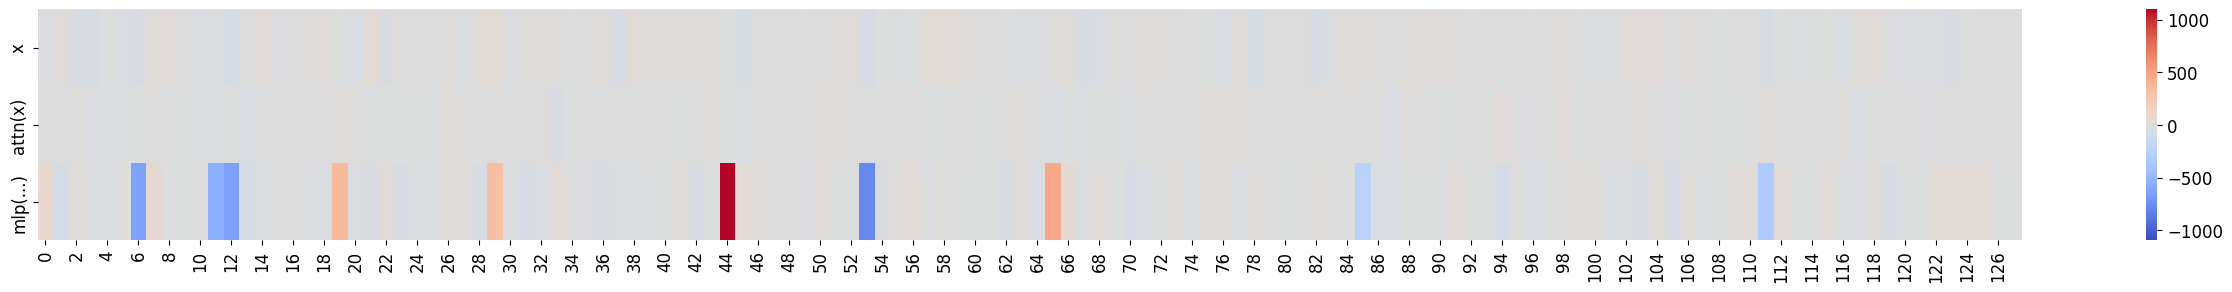

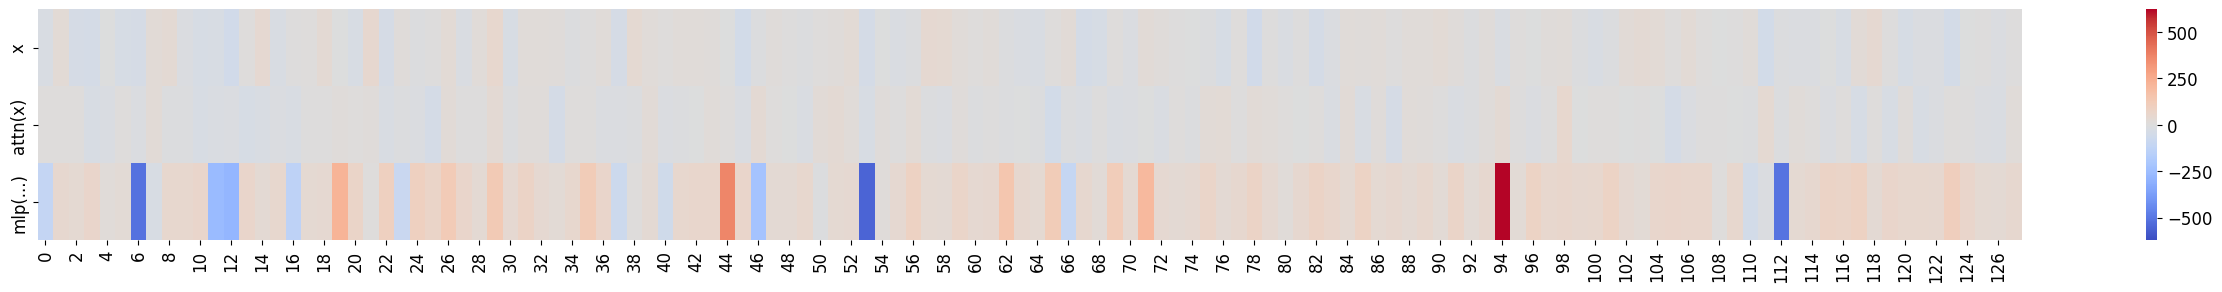

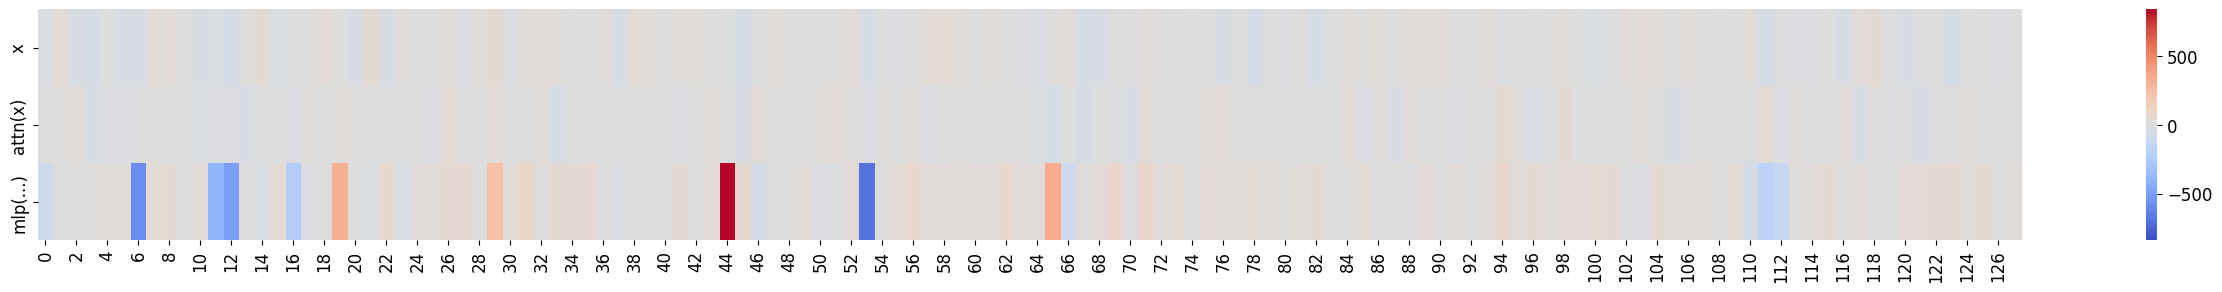

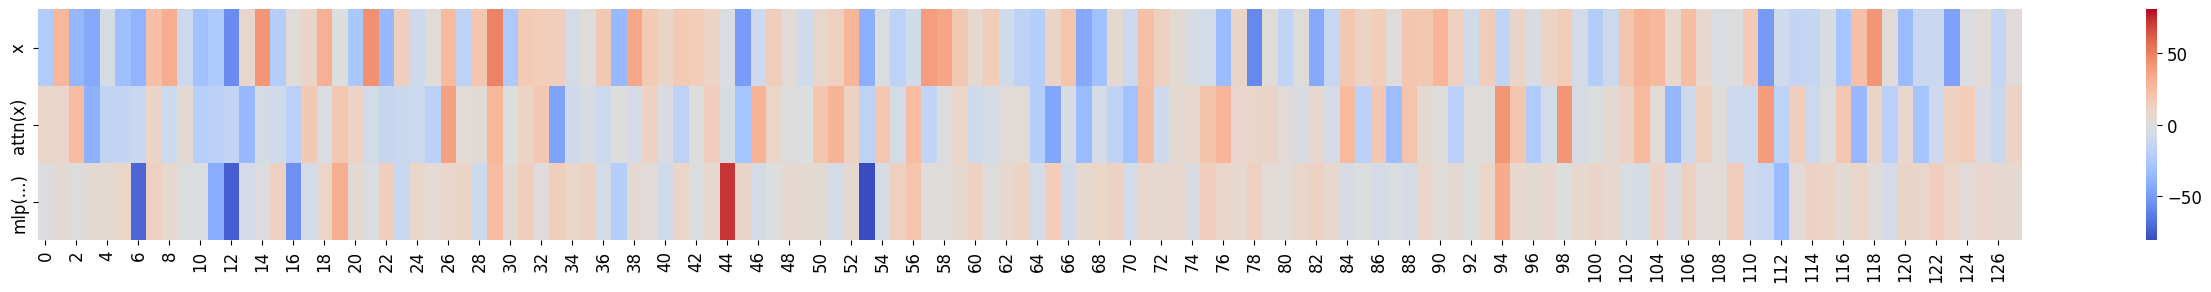

In [44]:
for tidx in range(dec, dec + length):
    m = max(abs(changes[:, tidx, :].min()), abs(changes[:, tidx, :].max()))
    plt.figure(figsize=(128 * 0.25, 3))
    sns.heatmap(changes[:, tidx, :].detach(), cmap='coolwarm', vmin=-m, vmax=m, yticklabels=['x', 'attn(x)', 'mlp(...)'])
    plt.show()

It seems like only the MLP output is significantly affected by the intervention.  
Does this hold even after the W(ln_f(.)) transform?

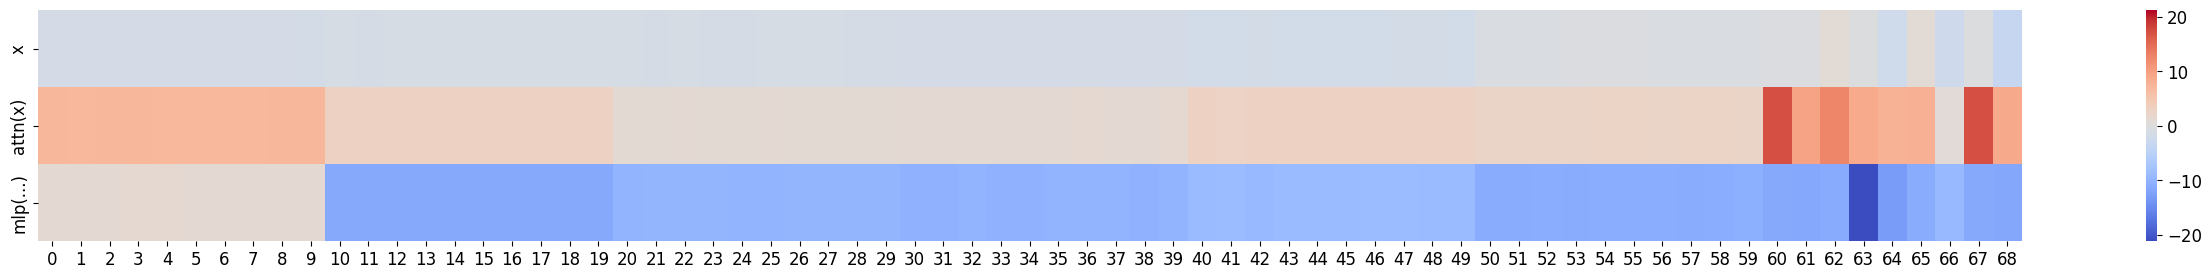

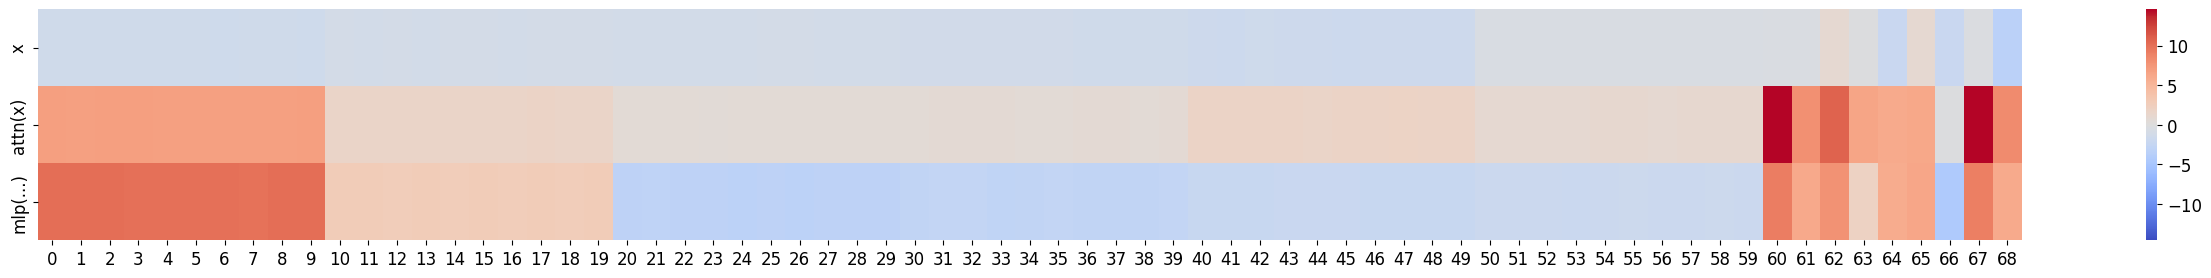

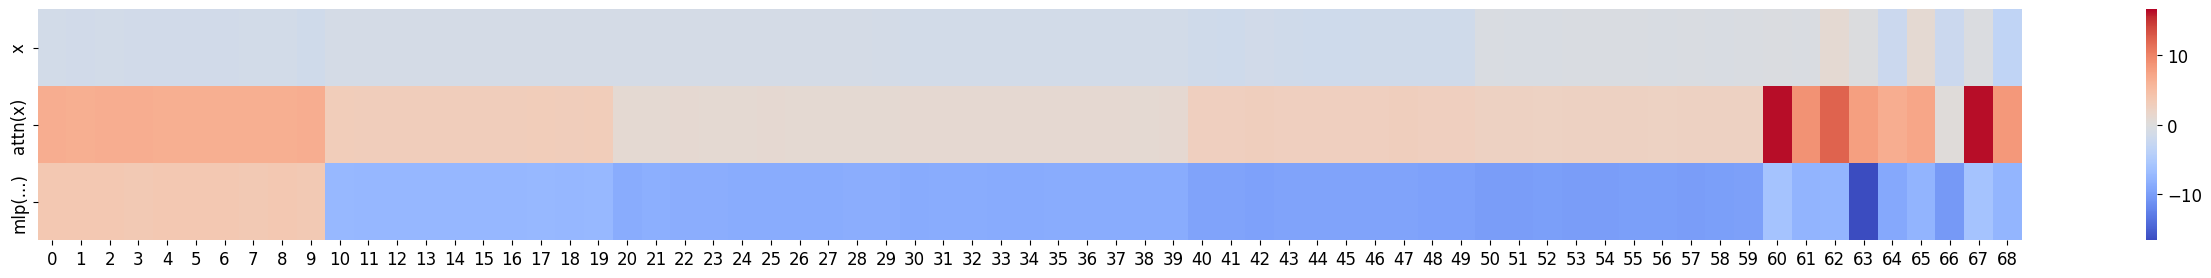

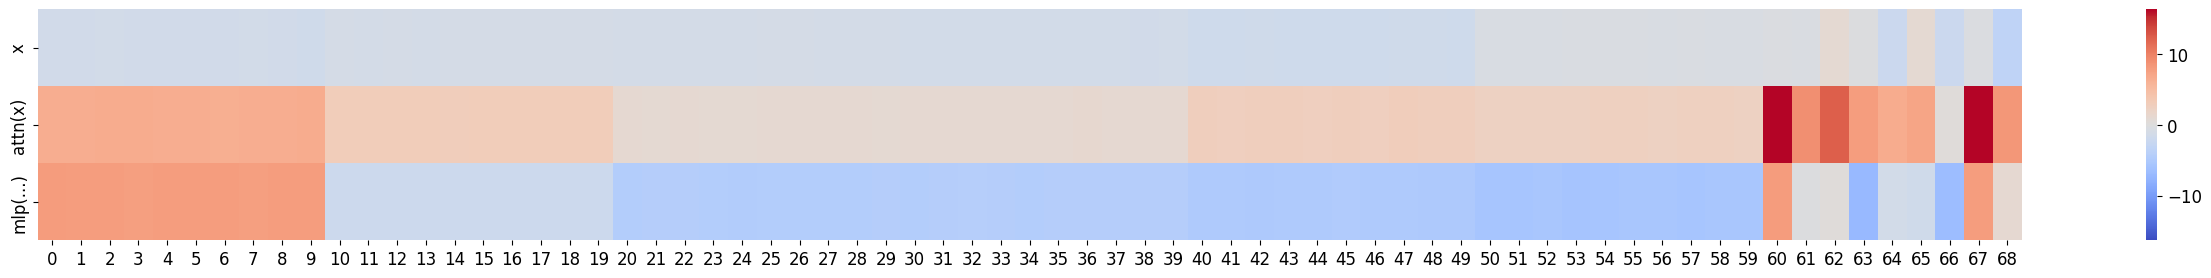

In [45]:
changes = torch.stack([model.LM_head(model.transformer.ln_f(change_in_reconstruction)),
                       model.LM_head(model.transformer.ln_f(change_in_attn)),
                       model.LM_head(model.transformer.ln_f(change_in_mlp))], dim=0)

for tidx in range(dec, dec + length):
    m = max(abs(changes[:, tidx, :].min()), abs(changes[:, tidx, :].max()))
    plt.figure(figsize=(128 * 0.25, 3))
    sns.heatmap(changes[:, tidx, :].detach(), cmap='coolwarm', vmin=-m, vmax=m, yticklabels=['x', 'attn(x)', 'mlp(...)'])
    plt.show()

Is the model output unchanged by the changes in the other two terms?

In [20]:
# Check if the model is still predicting the same token.
clean_logits.argmax(dim=-1) == \
model.LM_head(model.transformer.ln_f(clean_reconstruction + clean_attn + clean_mlp)).squeeze(0)[dec:dec+length].argmax(dim=-1)
# Check if the intervention has changed the prediction.
dirty_logits.argmax(dim=-1) == \
model.LM_head(model.transformer.ln_f(dirty_reconstruction + dirty_attn + dirty_mlp)).squeeze(0)[dec:dec+length].argmax(dim=-1)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True])

In [49]:
which_to_pick = [0, 0, 1] # 0 means clean, 1 means dirty
controlled_logits = \
    model.LM_head(
        model.transformer.ln_f(
            (clean_reconstruction if which_to_pick[0] == 0 else dirty_reconstruction) + \
            (clean_attn           if which_to_pick[1] == 0 else dirty_attn) + \
            (clean_mlp            if which_to_pick[2] == 0 else dirty_mlp)
            )).squeeze(0)[dec:dec+length]

print(clean_logits.argmax(dim=-1).numpy()) # true predictions
print(controlled_logits.argmax(dim=-1).numpy()) # predictions with clean mlp
print(dirty_logits.argmax(dim=-1).numpy()) # intervened predictions

print(F.kl_div(F.log_softmax(clean_logits, dim=-1), F.softmax(controlled_logits, dim=-1), reduction='batchmean'))
print(F.kl_div(F.log_softmax(controlled_logits, dim=-1), F.softmax(dirty_logits, dim=-1), reduction='batchmean'))

[ 4 19 20 19 20  4 59 66 19 66]
[ 4  4 23 19 23  4 59 66 19 66]
[ 4  4 23 19 23  4 59 66 19 66]
tensor(1.2932, grad_fn=<DivBackward0>)
tensor(0.0065, grad_fn=<DivBackward0>)


Therefore, we only consider the $\operatorname{MLP}(x + \operatorname{attn}(x))$ term. For starters, we compare the changes in $x$ and $\operatorname{attn}(x)$, and verify whether any one of them is enough to replicate the change in the MLP output.

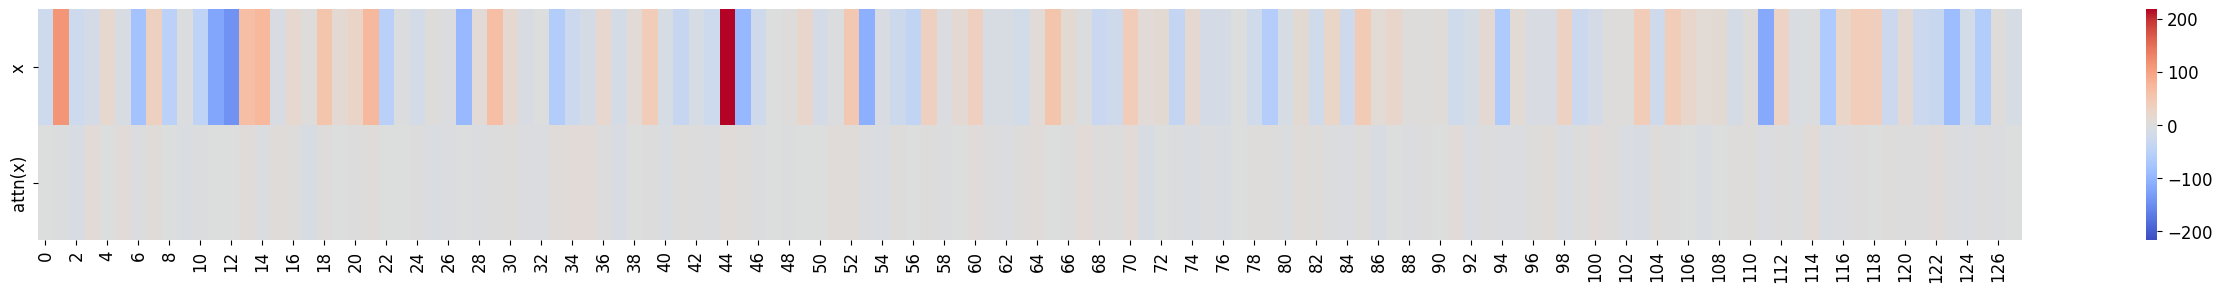

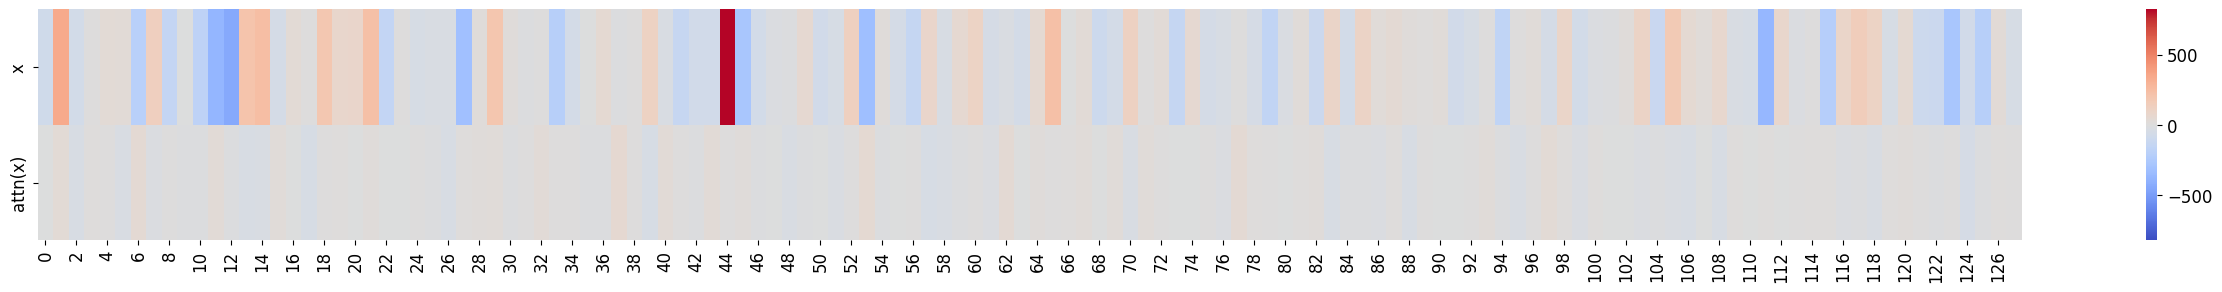

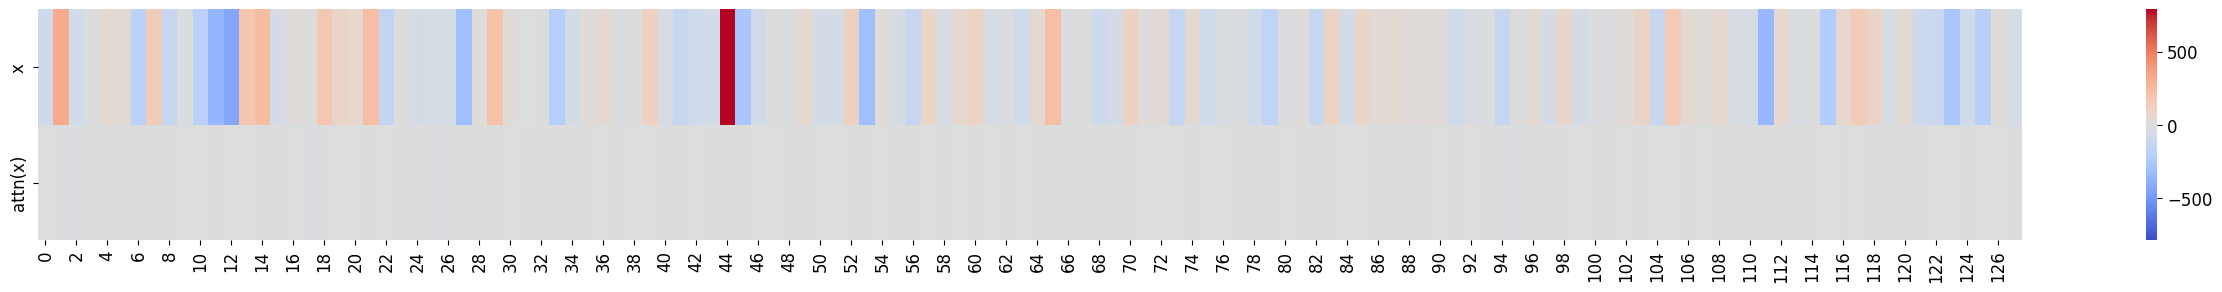

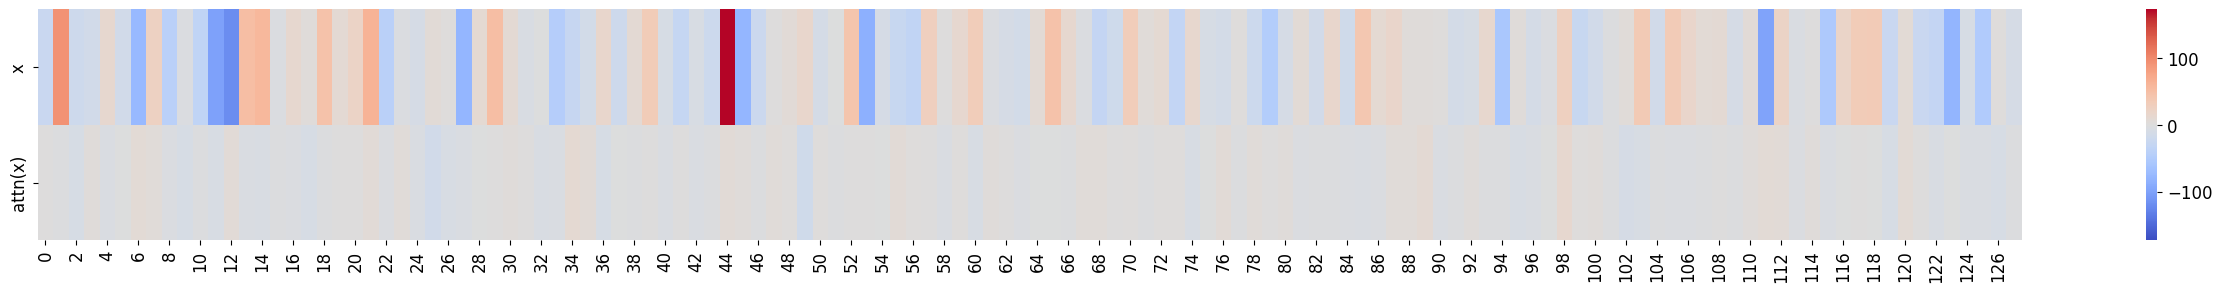

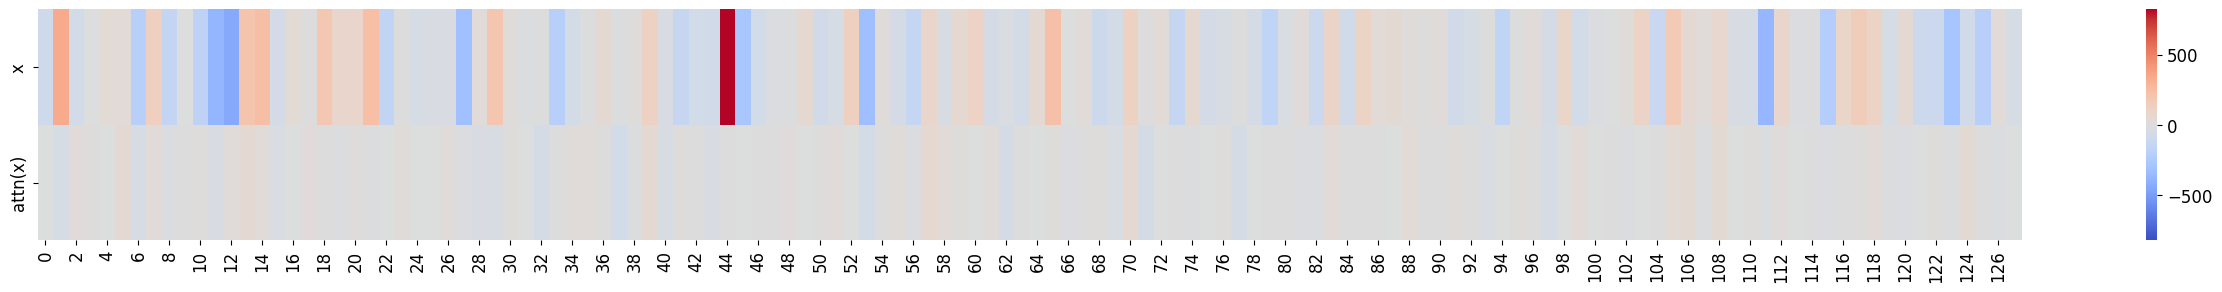

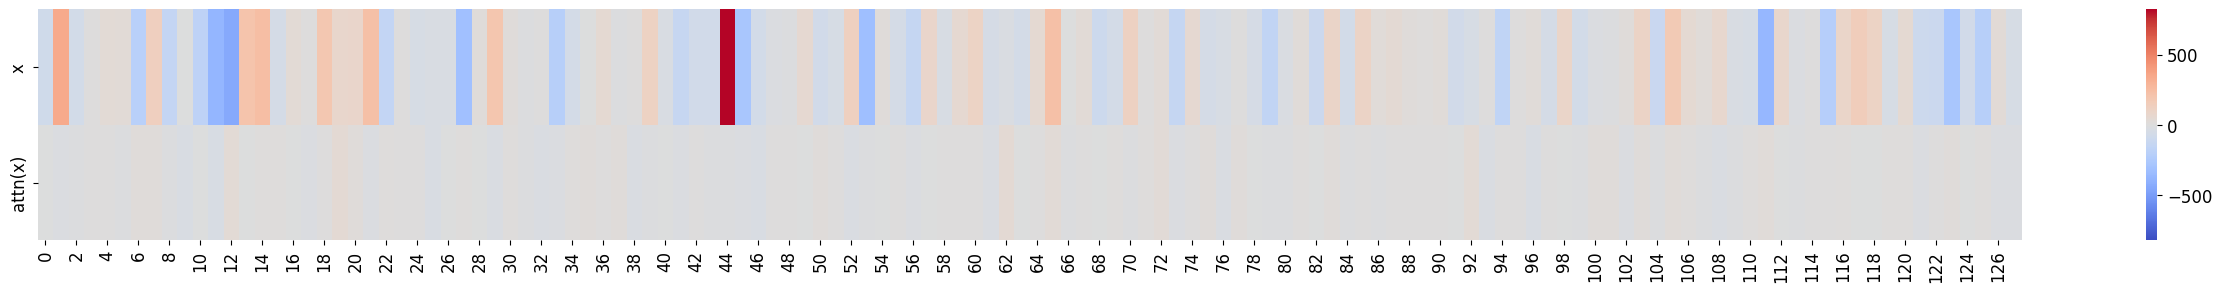

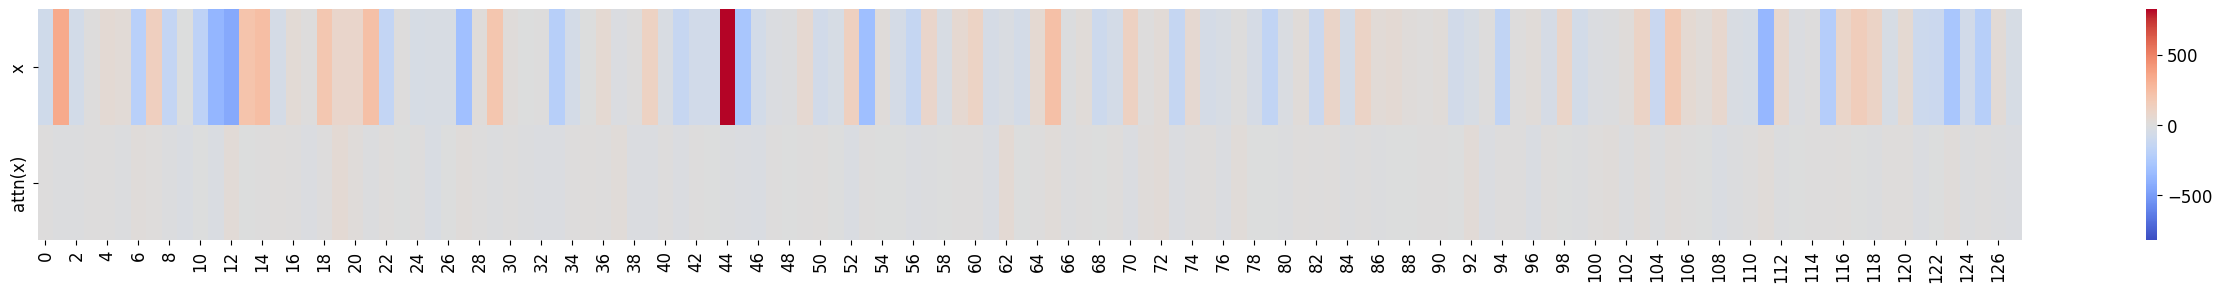

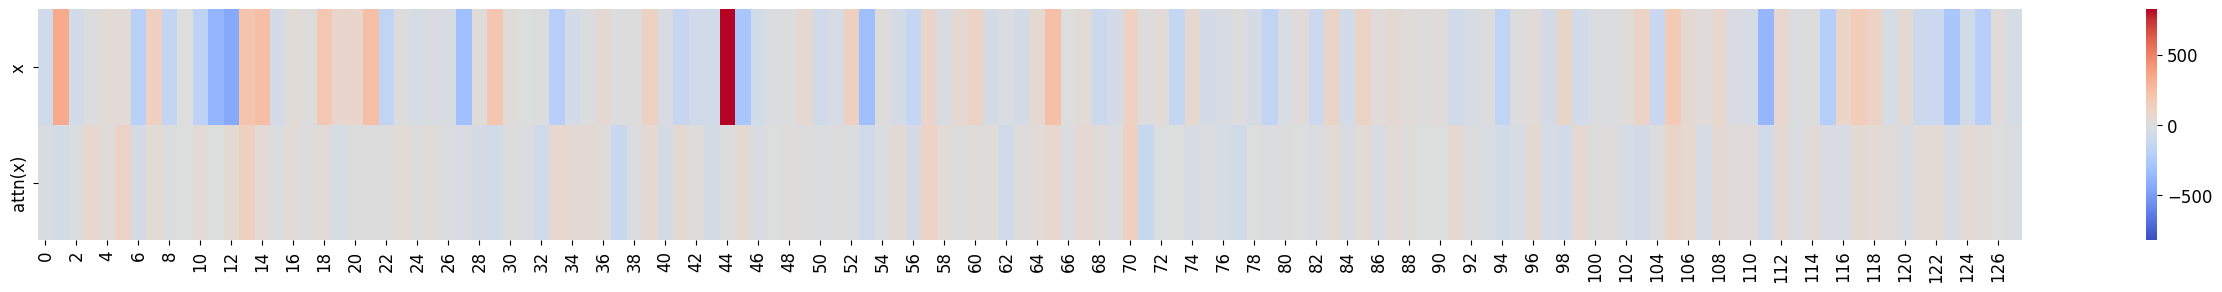

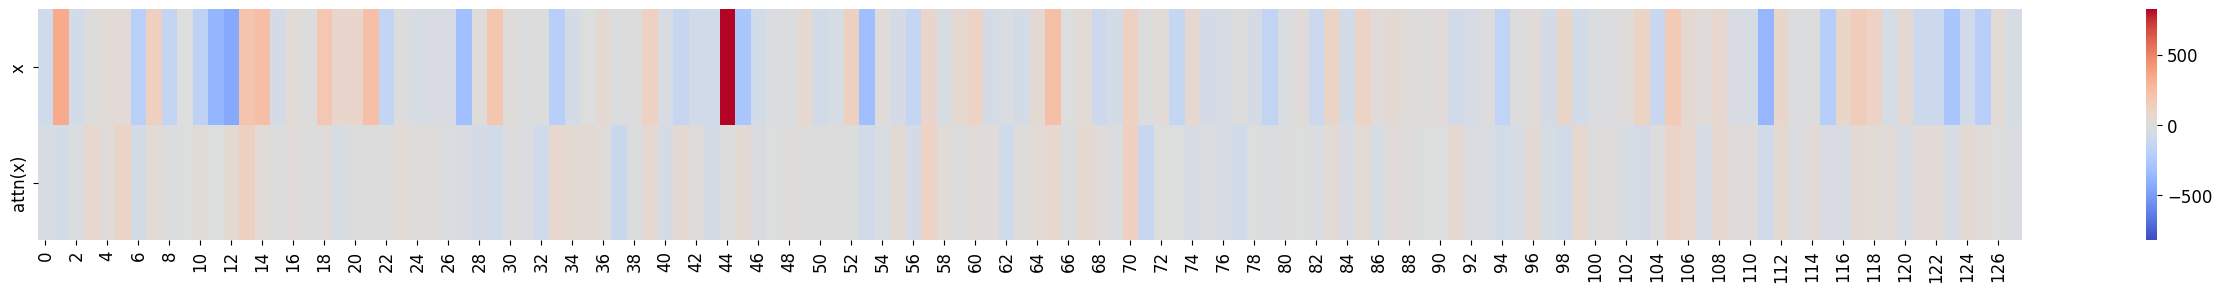

In [56]:
changes = torch.stack([change_in_reconstruction, change_in_attn], dim=0)
for tidx in range(dec, dec + length):
    m = max(abs(changes[:, tidx, :].min()), abs(changes[:, tidx, :].max()))
    plt.figure(figsize=(128 * 0.25, 3))
    sns.heatmap(changes[:, tidx, :].detach(), cmap='coolwarm', vmin=-m, vmax=m, yticklabels=['x', 'attn(x)'])
    plt.show()

In [51]:
which_to_pick = [0, 1] # 0 means clean, 1 means dirty
controlled_logits = \
    model.LM_head(
        model.transformer.ln_f(
            clean_reconstruction + clean_attn +  \
            model.transformer.h[1].mlp(
                (clean_reconstruction if which_to_pick[0] == 0 else dirty_reconstruction) + \
                (clean_attn           if which_to_pick[1] == 0 else dirty_attn)
            ))).squeeze(0)[dec:dec+length]

print(clean_logits.argmax(dim=-1).numpy()) # true predictions
print(controlled_logits.argmax(dim=-1).numpy()) # predictions with clean mlp
print(dirty_logits.argmax(dim=-1).numpy()) # intervened predictions

print(F.kl_div(F.log_softmax(clean_logits, dim=-1), F.softmax(controlled_logits, dim=-1), reduction='batchmean'))
print(F.kl_div(F.log_softmax(controlled_logits, dim=-1), F.softmax(dirty_logits, dim=-1), reduction='batchmean'))

[ 4 19 20 19 20  4 59 66 19 66]
[ 4 19 20 19 20  4 19 66 19 66]
[ 4  4 23 19 23  4 59 66 19 66]
tensor(0.0048, grad_fn=<DivBackward0>)
tensor(1.5305, grad_fn=<DivBackward0>)


Literally only the $\operatorname{MLP}(x)$ term matters.

Let
$$\operatorname{MLP} = x \mapsto W_2(\operatorname{GeLU}(W_1(x))).$$

This is essentially the same as the autoencoder architecture. Do the encoder or decoder columns map to columns of $W_1$ or $W_2$?

In [105]:
# Extract MLP weights and normalize
w1 = model.transformer.h[1].mlp.c_fc.weight.data.T # [128, 512]
w2 = model.transformer.h[1].mlp.c_proj.weight.data # [128, 512]
w1 = w1 / torch.norm(w1, dim=0, keepdim=True)
w2 = w2 / torch.norm(w2, dim=0, keepdim=True)

# Extract SAE weights and normalize
enc = sae.encoder[0].weight.data.T # [128, 256]
dec = sae.decoder.weight.data      # [128, 256]
enc = enc / torch.norm(enc, dim=0, keepdim=True)
dec = dec / torch.norm(dec, dim=0, keepdim=True)

# Compute pairwise cosine similarity between MLP and SAE weights
similarity = w1.T @ enc
print("W1-Encoder")
print("max:", similarity.max().item())
print("min:", similarity.min().item())

similarity = w2.T @ dec
print("W2-Decoder")
print("max:", similarity.max().item())
print("min:", similarity.min().item())

similarity = w1.T @ dec
print("W1-Decoder")
print("max:", similarity.max().item())
print("min:", similarity.min().item())

similarity = w2.T @ dec
print("W2-Encoder")
print("max:", similarity.max().item())
print("min:", similarity.min().item())

W1-Encoder
max: 0.6229584217071533
min: -0.5349461436271667
W2-Decoder
max: 0.5258594155311584
min: -0.49630698561668396
W1-Decoder
max: 0.6681309342384338
min: -0.6287774443626404
W2-Encoder
max: 0.5258594155311584
min: -0.49630698561668396


Can we analyze the MLP's projections to understand something about the features we identify?

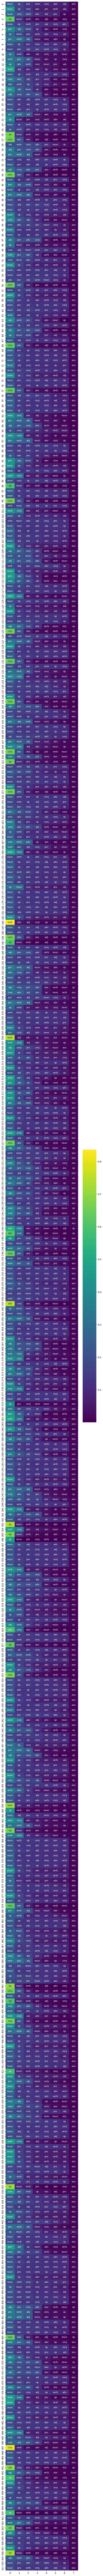

In [72]:
vocab_projections = model.LM_head(model.transformer.h[1].mlp.c_proj.weight.data.T) # [512, 69]
poses = ['noun', 'verb', 'adj', 'pro', 'adv', 'conj', 'eos', 'op']

probs = F.softmax(vocab_projections, dim=-1) # [512, 59]
pos_probs = [probs[:, 0:10].sum(dim=-1), # nouns # [512]
             probs[:, 10:20].sum(dim=-1), # verbs
             probs[:, 20:30].sum(dim=-1), # adjectives
             probs[:, 30:40].sum(dim=-1), # pronouns
             probs[:, 40:50].sum(dim=-1), # adverbs
             probs[:, 50:60].sum(dim=-1), # conjunctions
             probs[:, 66], # eos
             probs[:, 61:66].sum(dim=-1) + probs[:, 67:].sum(dim=-1)] # other
pos_probs = torch.stack(pos_probs, dim=-1) # [512, 8]
val, ind = torch.sort(pos_probs, dim=-1, descending=True)

plt.figure(figsize=(7.2, 0.4 * 512))
sns.heatmap(val.detach().numpy(), cmap='viridis', annot=[[poses[r] for r in row] for row in ind], fmt='')
plt.show()

In [119]:
def entropy_of_mlp_coefficients(fidx):
    mlp_coefficients = None
    def store_mlp_coeffs(module, input, output):
        nonlocal mlp_coefficients
        mlp_coefficients = input[0].clone().squeeze(0).squeeze(0)
    
    def pass_sparse_latent(module, input, output):
        latent = torch.zeros(256)
        latent[fidx] = 100
        recon = sae.decoder(latent.unsqueeze(0))
        return recon.unsqueeze(0)

    handle = module.register_forward_hook(pass_sparse_latent)
    handle_mlp = model.transformer.h[1].mlp.c_proj.register_forward_hook(store_mlp_coeffs)

    model(torch.tensor([[0]]))

    handle.remove()
    handle_mlp.remove()

    noun_dir_coeffs = mlp_coefficients[ind[:, 0] == 0].mean()
    return noun_dir_coeffs.detach()

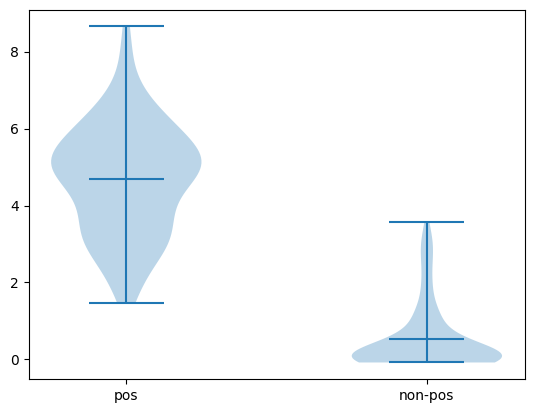

In [120]:
k = 5
pos_feats = get_feature_set(sae, 'adj', 0.9)[0]
non_pos_feats = [i for i in range(256) if i not in pos_feats]

p, r = [], []
for _ in range(100):
    p.append(entropy_of_mlp_coefficients(random.sample(pos_feats, k)))
    r.append(entropy_of_mlp_coefficients(random.sample(non_pos_feats, k)))

plt.violinplot([p, r], positions=[0, 1], showmeans=True)
plt.xticks([0, 1], labels=['pos', 'non-pos'])
plt.show()

## Adaptive Intervention

We define a hook that intervenes adaptively, *i.e.*, changes the activation by a multiplicative factor instead of a constant one.

In [81]:
def get_adaptive_hook(sae, fidx, factor):
    """fidx can be an index or a list of indices"""
    def hook(module, input, output):
        latent, _ = sae(output)
        latent[..., fidx] *= factor
        recon = sae.decoder(latent)
        return recon
    return hook

def get_complement_hook(sae, fidx, factor):
    def hook(module, input, output):
        latent, _ = sae(output)
        indices = [i for i in range(latent.size(-1)) if i not in fidx]
        latent[..., indices] *= factor
        recon = sae.decoder(latent)
        return recon
    return hook

We run a similar sweep.

In [120]:
sae = get_sae(3)
fidx, c = get_feature_set(sae, 'adj', 0.9)
print(fidx)
vmin, vmax = get_range_of_latent(sae, fidx)
print(vmin, vmax)

parts_of_speech = ['noun', 'pro', 'adj', 'verb', 'adv', 'conj']
dirtys = [[] for _ in range(6)]
grm = []
factors = [-1 + (2/10) * c for c in range(11)]
for factor in tqdm(factors):
    _, ds = fuck_with_model(get_adaptive_hook(sae, fidx, factor), [pos_fraction(pos) for pos in parts_of_speech] + [is_grammatical]) #[is_grammatical, depth])
    for i in range(6):
        dirtys[i].append(ds[i])
    grm.append(ds[-1])

/var/folders/7s/t502n_qs6zg3d8hynhr0prpm0000gn/T/ipykernel_19096/385031657.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path, f's

[84, 155, 227, 67, 139, 249, 79, 131, 242, 105, 220, 255, 179, 250, 210, 128]
tensor([ 84, 155, 227,  67, 139, 249,  79, 131, 242, 105, 220, 255, 179, 250,
        210, 128], dtype=torch.int32)
0.0 825.0484619140625


100%|██████████| 11/11 [01:18<00:00,  7.11s/it]


In [121]:
for i in range(6):
    dirtys[i] = [sum(c)/len(c) for c in dirtys[i]]

for i in range(1, 6):
    dirtys[i] = [d+d1 for d, d1 in zip(dirtys[i], dirtys[i-1])]

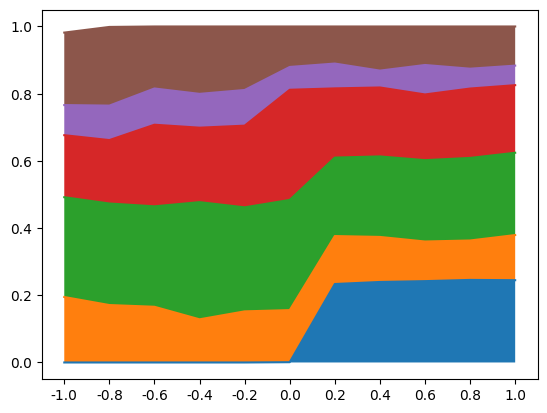

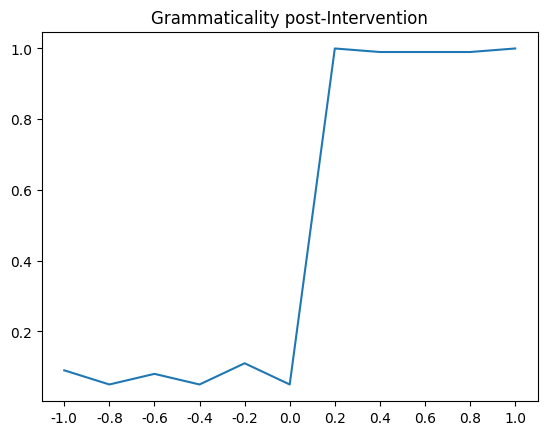

In [122]:
plt.plot(dirtys[0], label='noun')
plt.plot(dirtys[1], label='pro')
plt.plot(dirtys[2], label='adj')
plt.plot(dirtys[3], label='verb')
plt.plot(dirtys[4], label='adv')
plt.plot(dirtys[5], label='conj')
plt.fill_between(range(11), 0, dirtys[0])
plt.fill_between(range(11), dirtys[0], dirtys[1])
plt.fill_between(range(11), dirtys[1], dirtys[2])
plt.fill_between(range(11), dirtys[2], dirtys[3])
plt.fill_between(range(11), dirtys[3], dirtys[4])
plt.fill_between(range(11), dirtys[4], dirtys[5])

plt.xticks(range(11), labels=[f'{f:.1f}' for f in factors])
#plt.title("Depth post-Intervention")
#plt.legend()
plt.show()

plt.plot([sum(c)/len(c) for c in grm], label='Gram')
plt.xticks(range(11), labels=[f'{f:.1f}' for f in factors])
plt.title("Grammaticality post-Intervention")
plt.show()

## Other Interventions

In [81]:
activations = 0
def hook(module, input, output):
    global activations
    latent, _ = sae(output)
    activations = latent[:, -1, 206]
    latent[:, -1, 206] = 500 # max value
    recon = sae.decoder(latent)
    return recon

def stack(tokens):
    c = 1
    for t in tokens:
        if t[:-1] == 'dig': c -= 1
        if t[:-1] == 'bin': c += 1
        if t[:-1] == 'tern': c += 2
    return c

In [109]:
sae = get_sae(454)

batch = next(iter(dataloader))
batch = torch.stack([batch[0][i] for i, l in enumerate(batch[1]) if l >= 20])
inputs = batch[:, :17]

In [110]:
clean_samples, _ = model.sample(inputs=inputs, max_new_tokens=cfg.data.max_sample_length - 17, retrieve_llhoods='tokens', sampling_strategy='greedy')
handle = module.register_forward_hook(hook)
dirty_samples, _ = model.sample(inputs=inputs, max_new_tokens=cfg.data.max_sample_length - 17, retrieve_llhoods='tokens', sampling_strategy='greedy')
handle.remove()

for i in range(len(inputs)):
    seq = pcfg.detokenize_sentence(inputs[i][7:].tolist())
    print(seq)
    print(stack(seq.split()))
    e = clean_samples[i].tolist().index(25)
    print("Clean:", pcfg.detokenize_sentence(clean_samples[i][17:e].tolist()))
    e = dirty_samples[i].tolist().index(25)
    print("Dirty:", pcfg.detokenize_sentence(dirty_samples[i][17:e].tolist()))

bin2 tern0 tern1 un1 bin2 tern0 bin1 bin0 bin1 un1
12
Clean: dig6 dig6 dig6 dig6 dig6 dig9 dig9 dig9 dig9 dig9 dig9 dig6
Dirty: dig8 dig8 dig8 dig8 dig8 dig8 dig8 dig8 dig8 dig8 dig8 dig8
tern2 dig9 tern0 dig5 un1 bin2 bin1 dig6 tern2 tern2
8
Clean: dig9 dig9 dig9 dig9 dig9 dig9 dig9 dig6
Dirty: dig8 dig8 dig8 dig8 dig8 dig8 dig8 dig8
tern1 bin1 bin0 dig1 tern0 tern1 dig3 dig3 dig7 tern2
7
Clean: dig9 dig9 dig9 dig9 dig9 dig9 dig6
Dirty: dig8 dig8 dig8 dig8 dig8 dig8 dig8
tern0 bin2 dig6 tern0 dig6 dig4 tern2 tern2 dig1 dig1
5
Clean: dig9 dig9 dig9 dig9 dig6
Dirty: dig8 dig8 dig8 dig8 dig8
bin2 dig7 bin0 bin1 dig0 tern1 un2 dig4 bin2 dig6
3
Clean: dig9 dig9 dig9
Dirty: dig8 dig8 dig7
tern1 dig6 dig8 tern2 tern0 tern1 dig0 dig2 dig8 dig8
3
Clean: dig9 dig9 dig6
Dirty: dig8 dig8 dig7


In [ ]:
samples, per_token_logprobs = model.sample(
            inputs=inputs, 
            max_new_tokens=cfg.data.max_sample_length - 17, 
            retrieve_llhoods='tokens',
            )